In [ ]:
#This notebook is inspired by some notebooks of Eleftherios Garyfallidis available individually as ipynb files on dipy.org

!pip install dipy

%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 51.0 MB/s eta 0:00:00




# Connectivity Matrices, ROI Intersections and Density Maps

This example is meant to be an introduction to some of the streamline tools
available in DIPY_. Some of the functions covered in this example are
``target``, ``connectivity_matrix`` and ``density_map``. ``target`` allows one
to filter streamlines that either pass through or do not pass through some
region of the brain, ``connectivity_matrix`` groups and counts streamlines
based on where in the brain they begin and end, and finally, density map counts
the number of streamlines that pass through every voxel of some image.

To get started we'll need to have a set of streamlines to work with. We'll use
EuDX along with the CsaOdfModel to make some streamlines. Let's import the
modules and download the data we'll be using.


This is script is not transparent to you, as it is downloading underneath data. In practice, each time you do a tractography you need 3 files. One Nifti file with all gradient direction scans (a 4D file), a 2 textual files comprising the sensitivity of the DWI sequence (the b-vals), and the associated directions (the b-vecs). Lastly, you would need a T1 volume to create the mask.

You can find the files clearly visible here: https://www.kaggle.com/code/chrisfilo/diffusion-weighted-imaging-dwi-analysis-with-dipy/input

In [ ]:
import numpy as np
from scipy.ndimage import binary_dilation

from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti_data, load_nifti, save_nifti
from dipy.direction import peaks
from dipy.reconst import shm
from dipy.tracking import utils
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.stopping_criterion import BinaryStoppingCriterion
from dipy.tracking.streamline import Streamlines


hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')
label_fname = get_fnames('stanford_labels')
t1_fname = get_fnames('stanford_t1')

data, affine, hardi_img = load_nifti(hardi_fname, return_img=True)
labels = load_nifti_data(label_fname)
t1_data = load_nifti_data(t1_fname)
bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
gtab = gradient_table(bvals, bvecs)

  0%|          | 0/5578 [00:00<?, ? MB/s]

  0%|          | 0/1 [00:00<?, ? MB/s]

  0%|          | 0/1 [00:00<?, ? MB/s]

  0%|          | 0/4 [00:00<?, ? MB/s]

  0%|          | 0/1 [00:00<?, ? MB/s]

  0%|          | 0/71 [00:00<?, ? MB/s]

We've loaded an image called ``labels_img`` which is a map of tissue types such
that every integer value in the array ``labels`` represents an anatomical
structure or tissue type [#]_. For this example, the image was created so that
white matter voxels have values of either 1 or 2. We'll use
``peaks_from_model`` to apply the ``CsaOdfModel`` to each white matter voxel
and estimate fiber orientations which we can use for tracking. We will also
dilate this mask by 1 voxel to ensure streamlines reach the grey matter.

In the line "csa_model = CsaOdfModel(gtab, sh_order=6)" sh_order define the "L" as in the figure below:
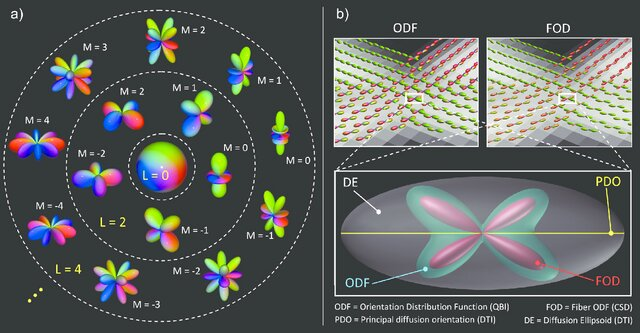


In [ ]:
white_matter = binary_dilation((labels == 1) | (labels == 2))
csamodel = shm.CsaOdfModel(gtab, 6)
csapeaks = peaks.peaks_from_model(model=csamodel,
                                  data=data,
                                  sphere=peaks.default_sphere,
                                  relative_peak_threshold=.8,
                                  min_separation_angle=45,
                                  mask=white_matter)

Now we can use EuDX to track all of the white matter. To keep things reasonably
fast we use ``density=1`` which will result in 1 seeds per voxel. The stopping
criterion, determining when the tracking stops, is set to stop when the
tracking exits the white matter.



In [ ]:
affine = np.eye(4)
seeds = utils.seeds_from_mask(white_matter, affine, density=1)
stopping_criterion = BinaryStoppingCriterion(white_matter)

streamline_generator = LocalTracking(csapeaks, stopping_criterion, seeds,
                                     affine=affine, step_size=0.5)
streamlines = Streamlines(streamline_generator)

The first of the tracking utilities we'll cover here is ``target``. This
function takes a set of streamlines and a region of interest (ROI) and returns
only those streamlines that pass through the ROI. The ROI should be an array
such that the voxels that belong to the ROI are ``True`` and all other voxels
are ``False`` (this type of binary array is sometimes called a mask). This
function can also exclude all the streamlines that pass through an ROI by
setting the ``include`` flag to ``False``. In this example we'll target the
streamlines of the corpus callosum. Our ``labels`` array has a sagittal slice
of the corpus callosum identified by the label value 2. We'll create an ROI
mask from that label and create two sets of streamlines, those that intersect
with the ROI and those that don't.

To see the labels look at the Nifti file with the labels (aparc-reduced.nii):
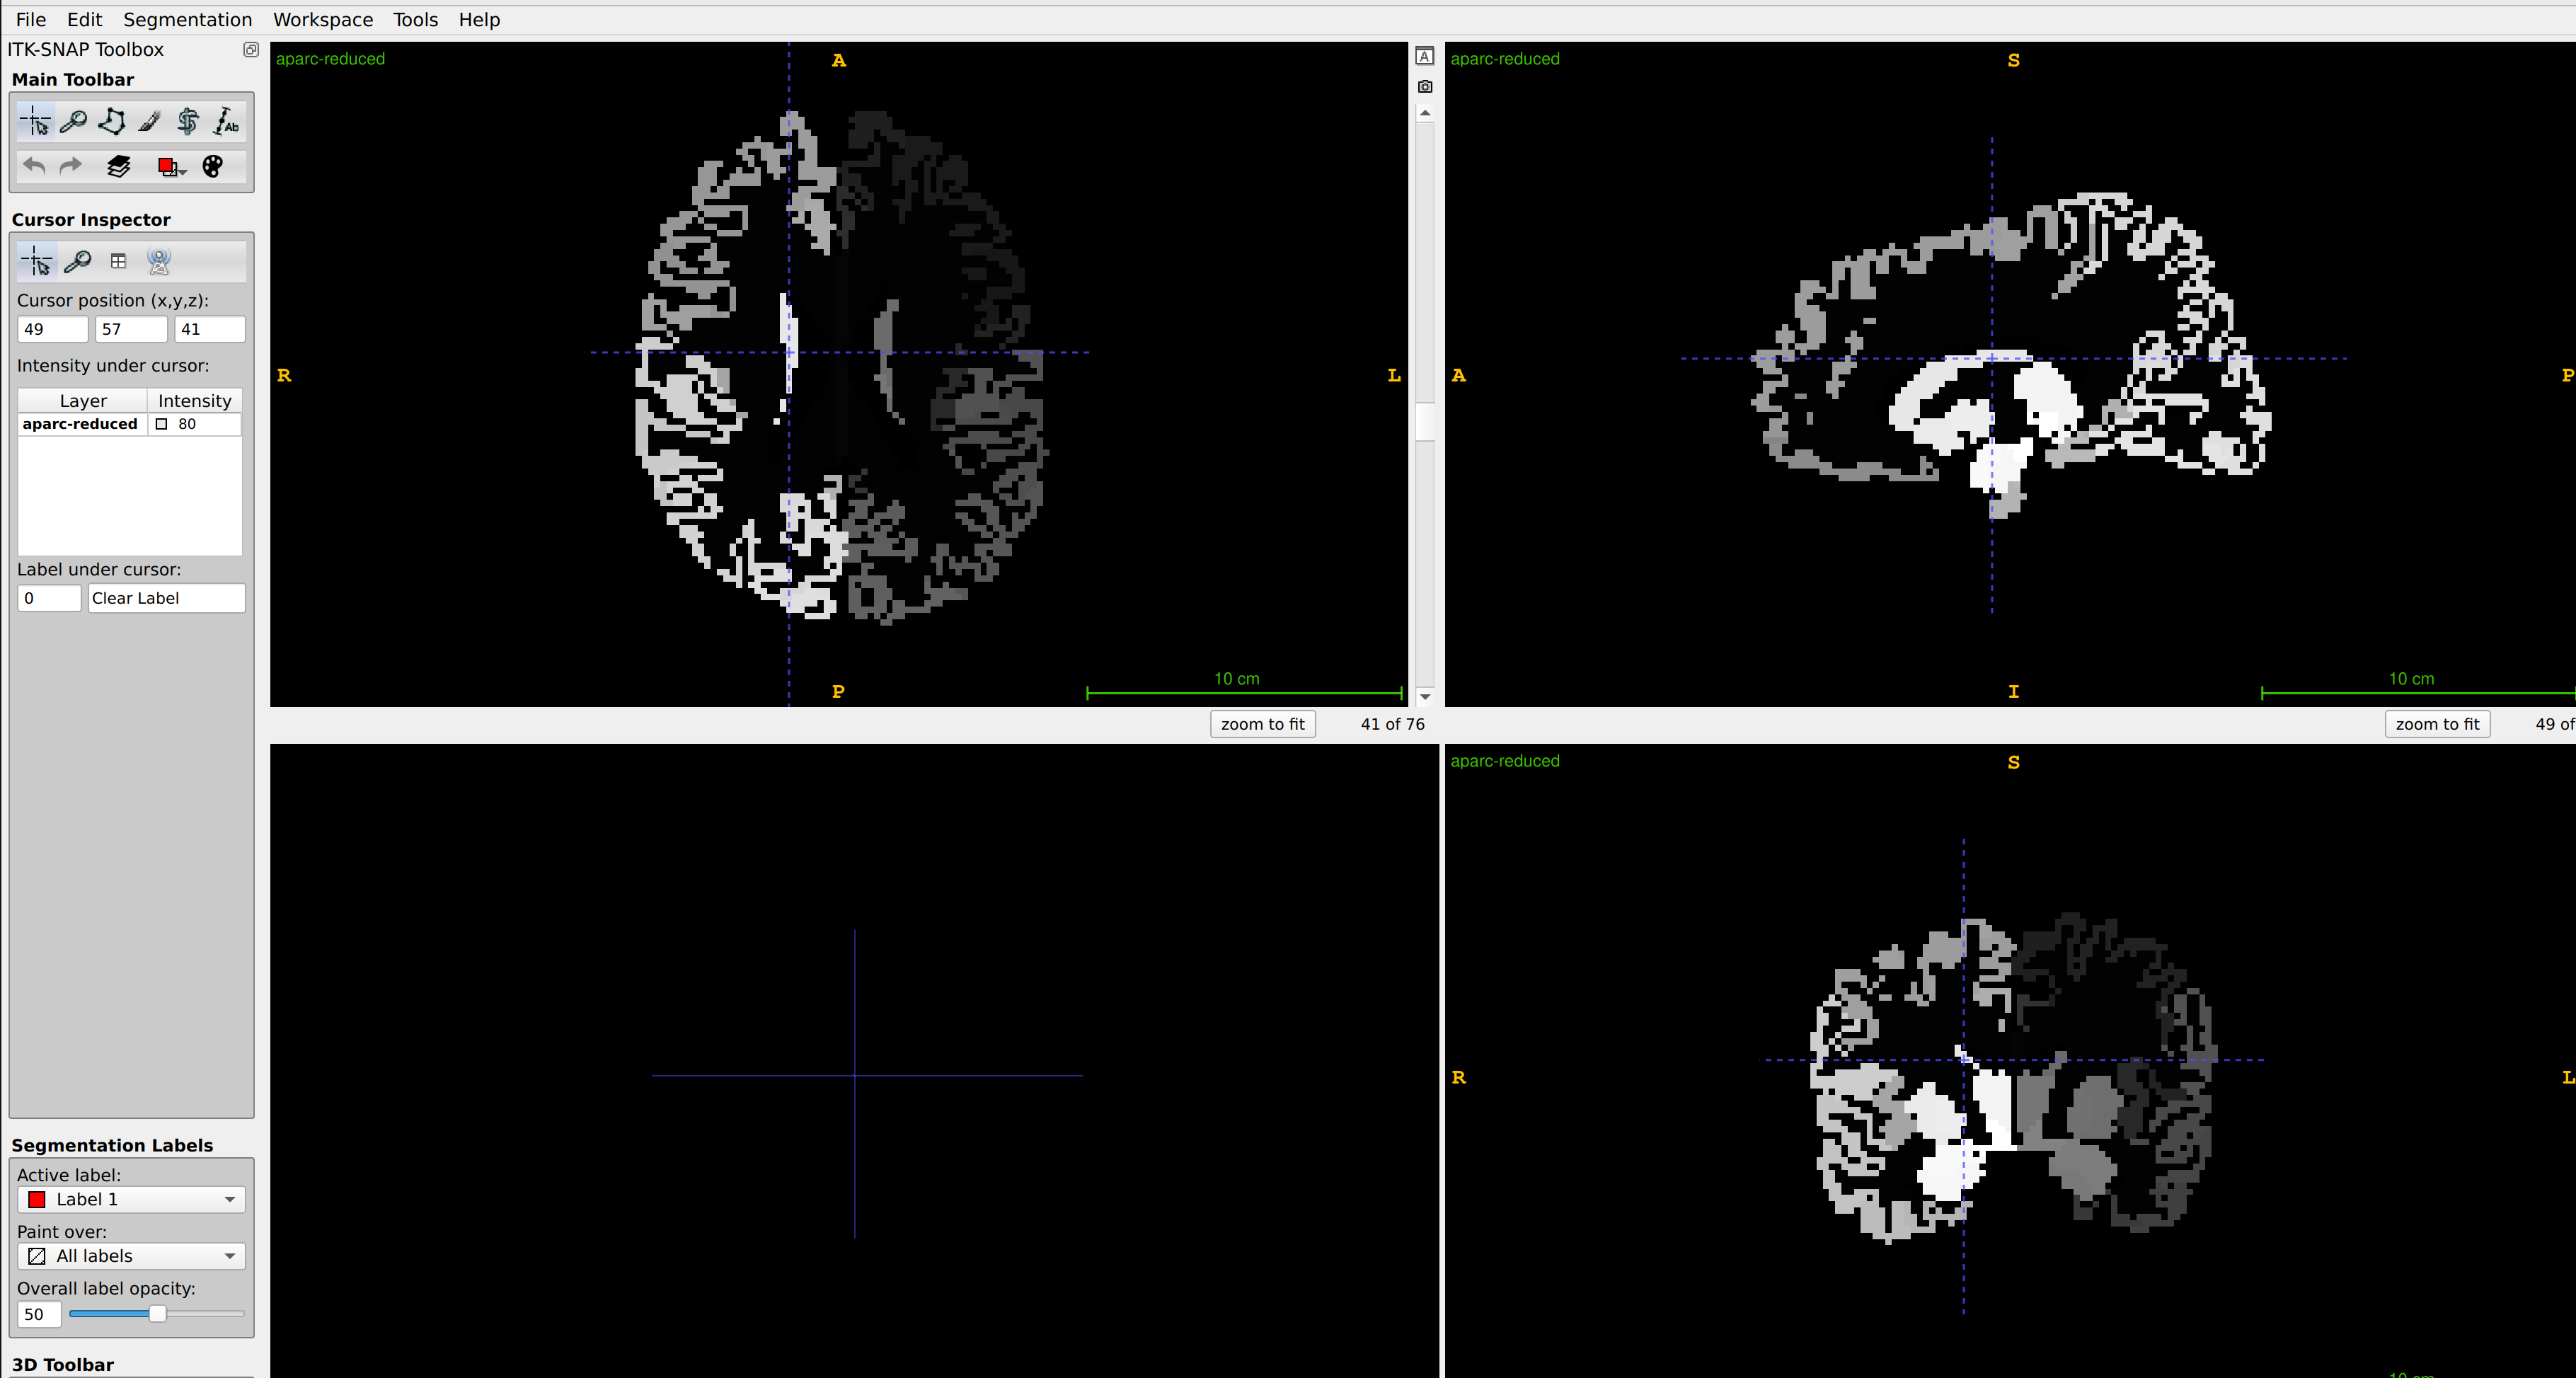


In [ ]:
cc_slice = labels == 2
cc_streamlines = utils.target(streamlines, affine, cc_slice)
cc_streamlines = Streamlines(cc_streamlines)

from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import save_trk

# Save streamlines
sft = StatefulTractogram(cc_streamlines, hardi_img, Space.VOX)
save_trk(sft, "cc_streamlines.trk")



other_streamlines = utils.target(streamlines, affine, cc_slice,
                                 include=False)
other_streamlines = Streamlines(other_streamlines)
assert len(other_streamlines) + len(cc_streamlines) == len(streamlines)

**Now let's visualize the generated tracts with Trackvis.**

Download it here, and keep the license file:
https://trackvis.org/download/

If you are running it on Ubuntu 22, you probably will need additional libraries:

sudo apt-get install libjpeg62


sudo add-apt-repository ppa:linuxuprising/libpng12

sudo apt update

sudo apt install libpng12-0

Once we've targeted the corpus callosum ROI, we might want to find out which
regions of the brain are connected by these streamlines. To do this we can use
the ``connectivity_matrix`` function. This function takes a set of streamlines
and an array of labels as arguments. It returns the number of streamlines that
start and end at each pair of labels and it can return the streamlines grouped
by their endpoints. Notice that this function only considers the endpoints of
each streamline.



In [ ]:
M, grouping = utils.connectivity_matrix(cc_streamlines, affine,
                                        labels.astype(np.uint8),
                                        return_mapping=True,
                                        mapping_as_streamlines=True)
M[:3, :] = 0
M[:, :3] = 0

We've set ``return_mapping`` and ``mapping_as_streamlines`` to ``True`` so that
``connectivity_matrix`` returns all the streamlines in ``cc_streamlines``
grouped by their endpoint.

Because we're typically only interested in connections between gray matter
regions, and because the label 0 represents background and the labels 1 and 2
represent white matter, we discard the first three rows and columns of the
connectivity matrix.

We can now display this matrix using matplotlib. We display it using a log
scale to make small values in the matrix easier to see.



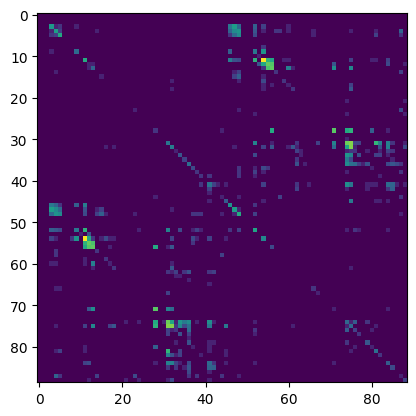

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(np.log1p(M), interpolation='nearest')
plt.savefig("connectivity.png")

In our example track there are more streamlines connecting regions 11 and
54 than any other pair of regions. These labels represent the left and right
superior frontal gyrus respectively. These two regions are large, close
together, have lots of corpus callosum fibers and are easy to track so this
result should not be a surprise to anyone.

However, the interpretation of streamline counts can be tricky. The
relationship between the underlying biology and the streamline counts will
depend on several factors, including how the tracking was done, and the correct
way to interpret these kinds of connectivity matrices is still an open question
in the diffusion imaging literature.

The next function we'll demonstrate is ``density_map``. This function allows
one to represent the spatial distribution of a track by counting the density of
streamlines in each voxel. For example, let's take the track connecting the
left and right superior frontal gyrus.

This is the screenshot from another example from Campanella et al. 2014
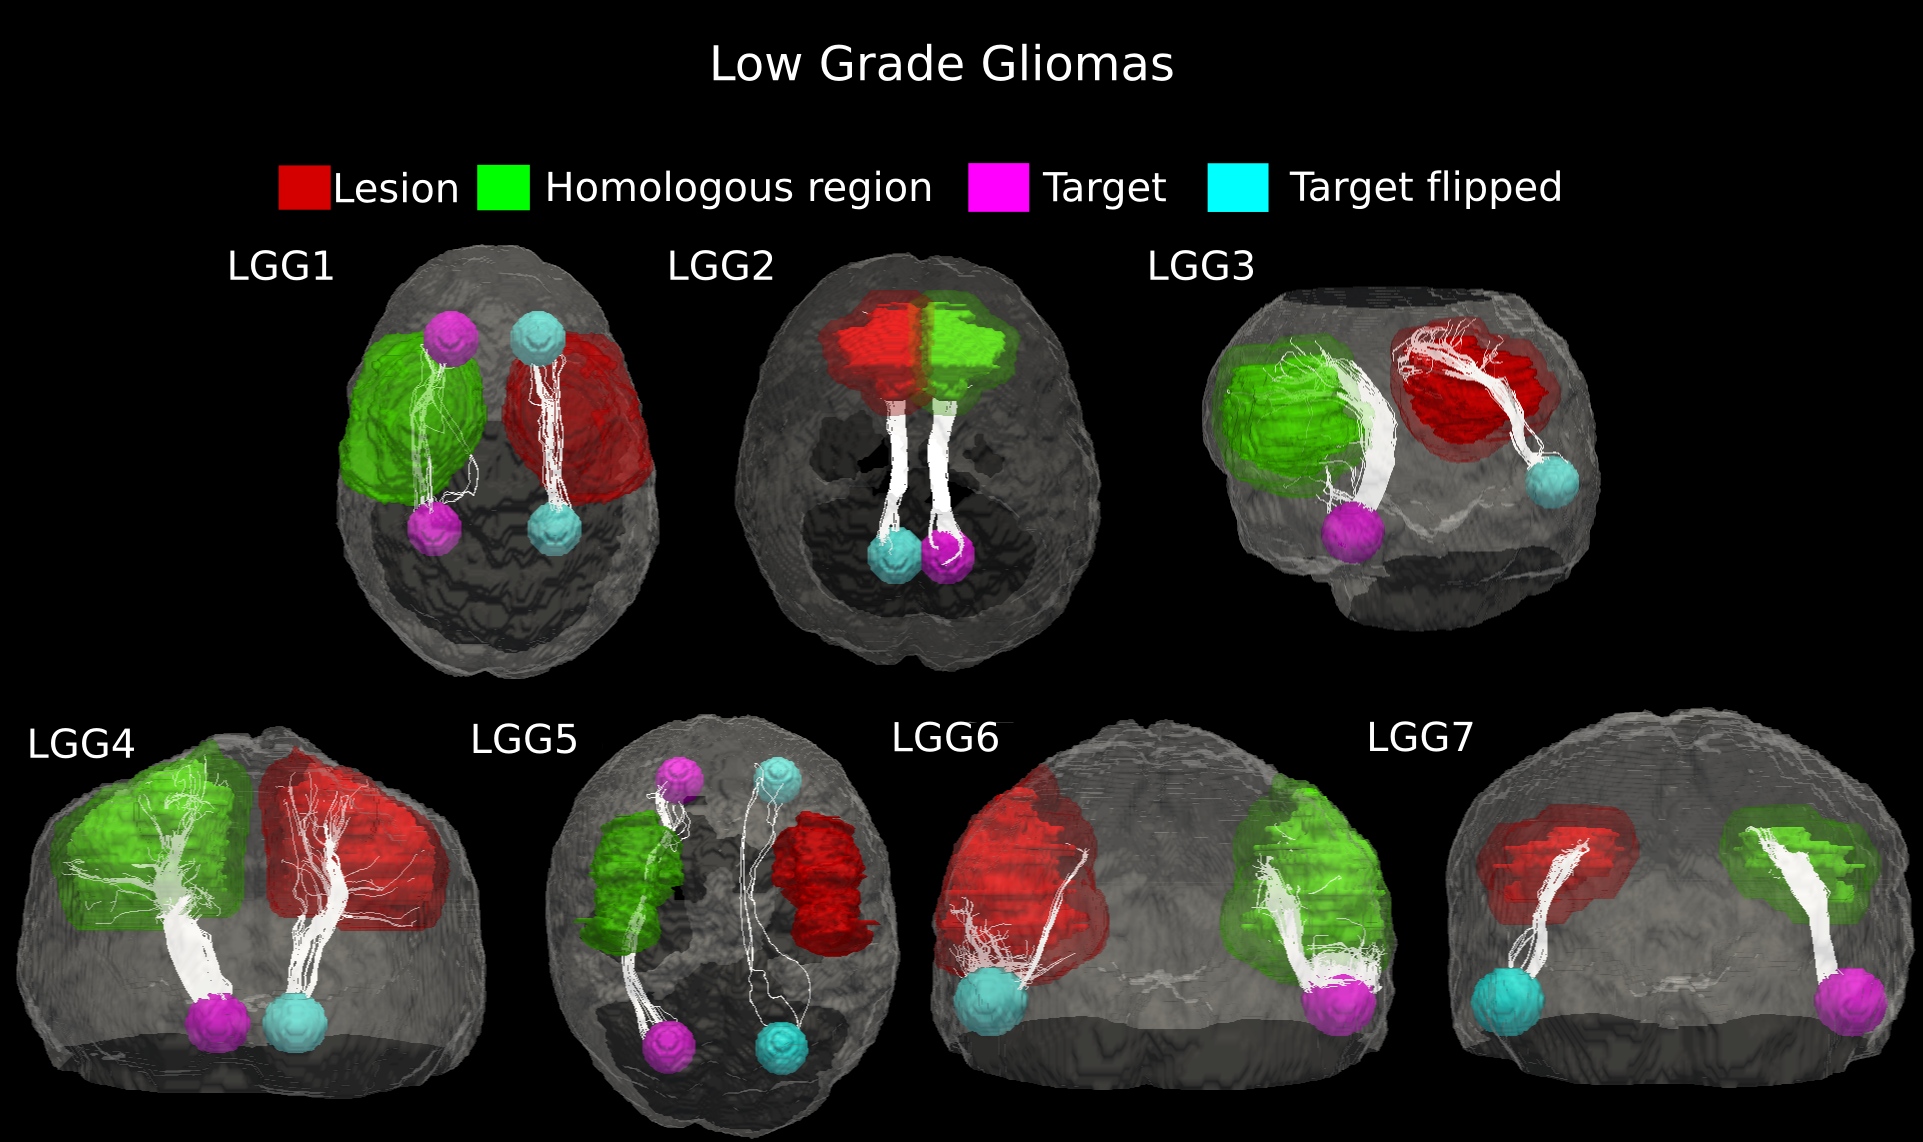



In [ ]:
lr_superiorfrontal_track = grouping[11, 54]
shape = labels.shape
dm = utils.density_map(lr_superiorfrontal_track, affine, shape)

Let's save this density map and the streamlines so that they can be
visualized together. In order to save the streamlines in a ".trk" file we'll
need to move them to "trackvis space", or the representation of streamlines
specified by the trackvis Track File format.




In [ ]:
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import save_trk

# Save density map
save_nifti("lr-superiorfrontal-dm.nii.gz", dm.astype("int16"), affine)

lr_sf_trk = Streamlines(lr_superiorfrontal_track)

# Save streamlines
sft = StatefulTractogram(lr_sf_trk, hardi_img, Space.VOX)
save_trk(sft, "lr-superiorfrontal.trk")

**Now we have two optional parts:**

**Part 1**

We can now do clustering (instead of the general Euclidean distance, we use the  minimum average direct-flip (MDF) distance and we set the minimum distance):




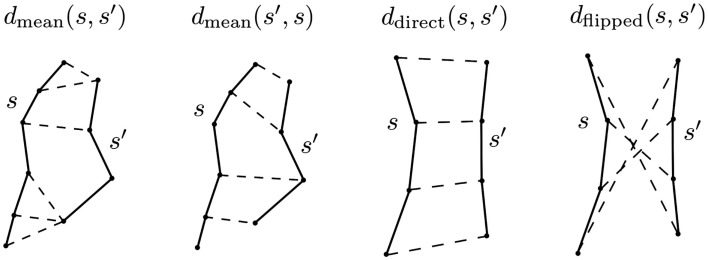


In [ ]:
from dipy.segment.clustering import QuickBundles
qb = QuickBundles(threshold=30.)
clusters = qb.cluster(streamlines)
print("Nb. clusters:", len(clusters))
print("Centroid of the last cluster:\n", clusters[-1].centroid)

Nb. clusters: 6
Streamlines indices of the first cluster:
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 

**Optional part 2**

Generate random variations  (one with more noise) of the connectivity matrix M  creating 2 datasets and run SVM to classify the two dataset (verctorized)

In [ ]:
#Jotted code on purpose probably wrong:

from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create Dataset 1
noise_level = 0.1  # Adjust this as needed

for....
    sample1 = M + np.random.normal(0, noise_level, M.shape)

noise_level2 = 0.5  # Adjust this as needed
noise = np.random.normal(0, noise_level2, M.shape)
  X1 append sample1
  y1 =   all 0

# Create Dataset 2
X2, y2 =  all 1

# Split datasets into training and testing sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Vectorize the data using StandardScaler
scaler = StandardScaler()
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)
X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)

# Train an SVM classifier on Dataset 1
svm1 = SVC(kernel='linear', C=1)
svm1.fit(X1_train_scaled, y1_train)

# Train an SVM classifier on Dataset 2
svm2 = SVC(kernel='linear', C=1)
svm2.fit(X2_train_scaled, y2_train)

# Predict on the test data
y1_pred = svm1.predict(X1_test_scaled)
y2_pred = svm2.predict(X2_test_scaled)

# Calculate accuracy for each dataset
accuracy1 = accuracy_score(y1_test, y1_pred)
accuracy2 = accuracy_score(y2_test, y2_pred)

print(f"Accuracy on Dataset 1: {accuracy1:.2f}")
print(f"Accuracy on Dataset 2: {accuracy2:.2f}")

.. rubric:: Footnotes

.. [#] The image `aparc-reduced.nii.gz`, which we load as ``labels_img``, is a
       modified version of label map `aparc+aseg.mgz` created by [FreeSurfer](https://surfer.nmr.mgh.harvard.edu/). The corpus callosum region is a
       combination of the FreeSurfer labels 251-255. The remaining FreeSurfer
       labels were re-mapped and reduced so that they lie between 0 and 88. To
       see the FreeSurfer region, label and name, represented by each value, see
       `label_info.txt` in `~/.dipy/stanford_hardi`.
.. [#] An affine transformation is a mapping between two coordinate systems
       that can represent scaling, rotation, shear, translation and reflection.
       Affine transformations are often represented using a 4x4 matrix where
       the last row of the matrix is ``[0, 0, 0, 1]``.

